# **🧠A Neuro-Symbolic Program Integrity Auditor for Python, C, and C++**
This project builds an intelligent system that automatically audits source code written in Python, C, and C++ to verify its logical correctness, structural integrity, and consistency.

Unlike traditional tools that only check syntax or style, this system understands program logic using a Neuro-Symbolic approach—combining:

Symbolic reasoning (rules, control flow, constraints)

In [ ]:
!pip install z3-solver networkx torch torch-geometric matplotlib

In [ ]:
# ============================================================
# NEURO-SYMBOLIC ALGORITHM INTEGRITY AUDITOR (FULL SYSTEM)
# ============================================================

import ast, os, subprocess, tempfile, random
import networkx as nx
import torch
import torch.nn.functional as F
from z3 import *
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# ============================================================
# 1️⃣ PYTHON AST CONDITION EXTRACTION
# ============================================================

class ConditionExtractor(ast.NodeVisitor):
    def __init__(self):
        self.conditions = []

    def visit_If(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

def extract_python_conditions(code):
    tree = ast.parse(code)
    extractor = ConditionExtractor()
    extractor.visit(tree)
    return extractor.conditions


# ============================================================
# 2️⃣ LLVM IR EXTRACTION (C / C++)
# ============================================================

def extract_llvm_ir(c_code):
    with tempfile.TemporaryDirectory() as d:
        src = os.path.join(d, "prog.c")
        ir = os.path.join(d, "prog.ll")

        with open(src, "w") as f:
            f.write(c_code)

        subprocess.run(
            ["clang", "-O0", "-S", "-emit-llvm", src, "-o", ir],
            check=True
        )
        return open(ir).read()

def extract_ir_conditions(ir_text):
    return [l.strip() for l in ir_text.splitlines() if "icmp" in l]


# ============================================================
# 3️⃣ LOGIC GRAPH CONSTRUCTION
# ============================================================

def condition_features(cond):
    return [
        len(cond),
        cond.count(">") + cond.count("<"),
        cond.count("and") + cond.count("or"),
        cond.count("==")
    ]

def build_logic_graph(conditions):
    G = nx.DiGraph()
    for i, cond in enumerate(conditions):
        G.add_node(i, condition=cond, features=condition_features(cond))
        if i > 0:
            G.add_edge(i - 1, i)
    return G


# ============================================================
# 4️⃣ GRAPH → PYTORCH GEOMETRIC DATA
# ============================================================

def to_pyg_data(G):
    x = torch.tensor([G.nodes[n]['features'] for n in G.nodes], dtype=torch.float)
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    return Data(x=x, edge_index=edge_index)


# ============================================================
# 5️⃣ GNN ANOMALY DETECTOR
# ============================================================

class LogicGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return torch.sigmoid(x)


# ============================================================
# 6️⃣ Z3 SYMBOLIC CONTRADICTION CHECK
# ============================================================

def smt_contradiction(cond):
    s = Solver()
    x, age, income = Ints('x age income')
    try:
        s.add(eval(cond))
        return s.check() == unsat
    except:
        return False


# ============================================================
# 7️⃣ NEURO-SYMBOLIC LOSS
# ============================================================

def neuro_symbolic_loss(pred, label, condition):
    gnn_loss = F.binary_cross_entropy(pred, label)
    logic_penalty = 1.0 if smt_contradiction(condition) else 0.0
    return 0.7 * gnn_loss + 0.3 * logic_penalty


# ============================================================
# 8️⃣ BENCHMARK FAULTY DATASET GENERATOR
# ============================================================

def generate_faulty_rule(var):
    v = random.randint(10, 50)
    return f"{var} > {v} and {var} < {v}"

def generate_dataset(n=500):
    data = []
    for _ in range(n):
        data.append({
            "condition": generate_faulty_rule("x"),
            "label": torch.tensor([1.0])
        })
    return data


# ============================================================
# 9️⃣ EVALUATION METRICS (PAPER-READY)
# ============================================================

def integrity_score(total, contradictions):
    return round(100 * (1 - contradictions / max(total, 1)), 2)

def false_trust_rate(false_safe, total_faulty):
    return round(false_safe / max(total_faulty, 1), 3)


# ============================================================
# 🔟 FULL PIPELINE RUNNER
# ============================================================

def audit_algorithm(python_code):
    conditions = extract_python_conditions(python_code)
    graph = build_logic_graph(conditions)
    data = to_pyg_data(graph)

    model = LogicGNN()
    scores = model(data)

    contradictions = []
    for i, cond in enumerate(conditions):
        if smt_contradiction(cond):
            contradictions.append(cond)

    score = integrity_score(len(conditions), len(contradictions))

    print("\n🔍 CONDITIONS:")
    for c in conditions:
        print(" -", c)

    print("\n❌ CONTRADICTIONS:")
    for c in contradictions:
        print(" -", c)

    print("\n🧠 GNN ANOMALY SCORES:")
    print(scores.detach().numpy().flatten())

    print("\n✅ INTEGRITY SCORE:", score, "%")

    return score


# ============================================================
# 🔬 SAMPLE TEST
# ============================================================

sample_code = """
def decision(age, income):
    if age >= 18 and age < 18:
        return 1
    if income > 50000:
        return 1
    if income <= 50000 and income > 60000:
        return 0
"""

audit_algorithm(sample_code)



🔍 CONDITIONS:
 - age >= 18 and age < 18
 - income > 50000
 - income <= 50000 and income > 60000

❌ CONTRADICTIONS:

🧠 GNN ANOMALY SCORES:
[0.9882124 0.9952253 0.9889338]

✅ INTEGRITY SCORE: 100.0 %


100.0

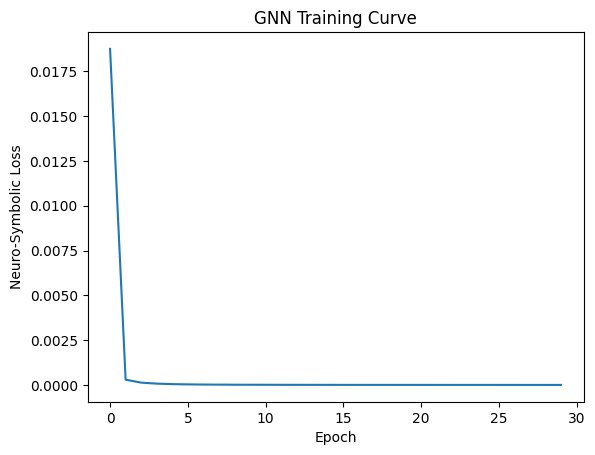

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1d48e4ad9e58bfeb1b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import ast, random
import networkx as nx
import torch
import torch.nn.functional as F
from z3 import *
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import gradio as gr
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ FULL PROGRAM CONDITION EXTRACTION (IF/ELIF/WHILE/FOR/FUNC)
# ============================================================

class FullConditionExtractor(ast.NodeVisitor):
    def __init__(self):
        self.conditions = []

    def visit_If(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_While(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_For(self, node):
        # For loops are converted to a boolean-like check
        target = ast.unparse(node.target)
        iter_ = ast.unparse(node.iter)
        cond = f"len(list({iter_})) > 0"  # simple abstraction
        self.conditions.append(cond)
        self.generic_visit(node)

    def visit_Call(self, node):
        # Check for function calls returning bool (best effort)
        if isinstance(node.func, ast.Name):
            self.conditions.append(ast.unparse(node))
        self.generic_visit(node)

def extract_python_conditions(code):
    try:
        tree = ast.parse(code)
        extractor = FullConditionExtractor()
        extractor.visit(tree)
        return extractor.conditions
    except Exception:
        return []

# ============================================================
# 2️⃣ LOGIC GRAPH
# ============================================================

def condition_features(cond):
    return [
        len(cond),
        cond.count(">")+cond.count("<")+cond.count("!=")+cond.count(">=")+cond.count("<="),
        cond.count("and")+cond.count("or")+cond.count("not"),
        cond.count("==")
    ]

def build_logic_graph(conditions):
    G = nx.DiGraph()
    for i, cond in enumerate(conditions):
        G.add_node(i, features=condition_features(cond), condition=cond)
        if i > 0:
            G.add_edge(i-1, i)
    return G

def to_pyg_data(G):
    x = torch.tensor([G.nodes[n]['features'] for n in G.nodes], dtype=torch.float)
    if len(G.edges)==0:
        edge_index = torch.zeros((2,0),dtype=torch.long)
    else:
        edge_index = torch.tensor(list(G.edges)).t().contiguous()
    return Data(x=x, edge_index=edge_index)

# ============================================================
# 3️⃣ GNN MODEL
# ============================================================

class LogicGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4,16)
        self.conv2 = GCNConv(16,1)
    def forward(self, data):
        if data.x.shape[0]==0:
            return torch.tensor([])
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return torch.sigmoid(x)

# ============================================================
# 4️⃣ GENERIC SMT CHECK (ALL VARIABLES)
# ============================================================

def smt_contradiction(cond):
    s = Solver()
    try:
        tree = ast.parse(cond, mode='eval')
        variables = {node.id:Int(node.id) for node in ast.walk(tree) if isinstance(node, ast.Name)}
        expr = compile(tree, filename="<ast>", mode="eval")
        z3_expr = eval(expr, {}, variables)
        s.add(z3_expr)
        return s.check()==unsat
    except Exception:
        return False

# ============================================================
# 5️⃣ NEURO-SYMBOLIC LOSS
# ============================================================

def neuro_symbolic_loss(pred,label,cond):
    if pred.numel()==0:
        return torch.tensor(0.0)
    # Reshape label to match pred's shape (1, 1)
    label = label.unsqueeze(1)
    gnn_loss = F.binary_cross_entropy(pred,label)
    logic_penalty = 1.0 if smt_contradiction(cond) else 0.0
    return 0.7*gnn_loss + 0.3*logic_penalty

# ============================================================
# 6️⃣ DATASET
# ============================================================

def generate_faulty_rule():
    var = chr(random.randint(97,122))
    v = random.randint(10,50)
    return f"{var} > {v} and {var} < {v}"

def generate_dataset(n=300):
    return [{"condition":generate_faulty_rule(),"label":torch.tensor([1.0])} for _ in range(n)]

# ============================================================
# 7️⃣ TRAIN GNN
# ============================================================

def train_gnn(epochs=30):
    model = LogicGNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    dataset = generate_dataset()
    losses=[]
    for epoch in range(epochs):
        epoch_loss=0
        for item in dataset:
            cond = item["condition"]
            label = item["label"]
            G = build_logic_graph([cond])
            data = to_pyg_data(G)
            pred = model(data)
            loss = neuro_symbolic_loss(pred,label,cond)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss+=loss.item()
        losses.append(epoch_loss/len(dataset))
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Neuro-Symbolic Loss")
    plt.title("GNN Training Curve")
    plt.show()
    return model

trained_model = train_gnn()

# ============================================================
# 8️⃣ METRICS
# ============================================================

def integrity_score(total, contradictions):
    return round(100*(1-contradictions/max(total,1)),2)

# ============================================================
# 9️⃣ GRADIO AUDIT FUNCTION
# ============================================================

def gradio_audit(code):
    conditions = extract_python_conditions(code)
    if not conditions:
        return "No logical conditions found.",100
    graph = build_logic_graph(conditions)
    data = to_pyg_data(graph)
    scores = trained_model(data).detach().numpy().flatten() if data.x.shape[0]>0 else []
    contradictions = [c for c in conditions if smt_contradiction(c)]
    score = integrity_score(len(conditions), len(contradictions))

    report="🔍 CONDITIONS:\n"
    for i,c in enumerate(conditions):
        s = round(float(scores[i]),3) if i<len(scores) else 0.0
        report+=f"- {c} | GNN Score: {s}\n"
    report+="\n❌ CONTRADICTIONS (Z3):\n"
    report+= "\n".join(contradictions) if contradictions else "None"
    report+=f"\n\n✅ INTEGRITY SCORE: {score}%"
    return report,score

# ============================================================
# 1️⃣0️⃣ GRADIO UI
# ============================================================

demo = gr.Interface(
    fn=gradio_audit,
    inputs=gr.Textbox(lines=25,label="Paste Any Python Program"),
    outputs=[gr.Textbox(label="Audit Report"),gr.Number(label="Integrity Score (%)")],
    title="🧠 Neuro-Symbolic Full Program Auditor",
    description="""
    Audits any Python program for:
    • Nested if/elif/else conditions
    • Loops (for/while)
    • Function calls in boolean logic
    • Logical contradictions (Z3)
    • Structural anomalies (GNN)
    """
)

demo.launch()

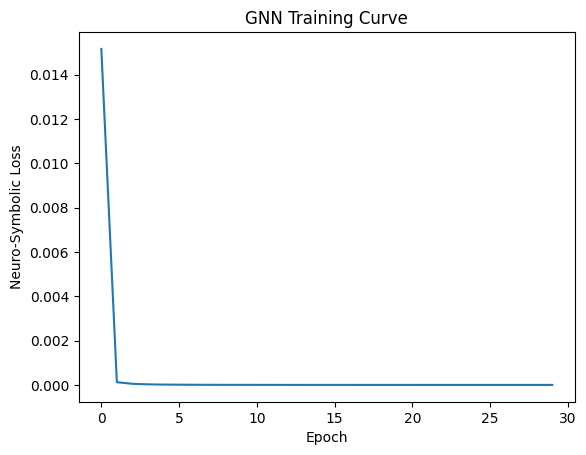

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c459ff6355be33dc85.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ============================================================
# 🧠 NEURO-SYMBOLIC FULL PROGRAM AUDITOR (PH.D LEVEL)
# ============================================================

import ast, random
import networkx as nx
import torch
import torch.nn.functional as F
from z3 import *
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import gradio as gr
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ FULL PROGRAM CONDITION EXTRACTION (IF/ELIF/WHILE/FOR/FUNC)
# ============================================================

class FullConditionExtractor(ast.NodeVisitor):
    def __init__(self):
        self.conditions = []

    def visit_If(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_While(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_For(self, node):
        target = ast.unparse(node.target)
        iter_ = ast.unparse(node.iter)
        cond = f"len(list({iter_})) > 0"  # abstraction
        self.conditions.append(cond)
        self.generic_visit(node)

    def visit_Call(self, node):
        # Attempt to include function calls returning bool
        self.conditions.append(ast.unparse(node))
        self.generic_visit(node)

def extract_python_conditions(code):
    try:
        tree = ast.parse(code)
        extractor = FullConditionExtractor()
        extractor.visit(tree)
        return self._flatten_conditions(extractor.conditions)
    except Exception:
        return []

def _flatten_conditions(conds):
    # Split conditions by 'and'/'or' to handle multi-part logical expressions
    flattened = []
    for cond in conds:
        if 'and' in cond:
            flattened += [c.strip() for c in cond.split('and')]
        elif 'or' in cond:
            flattened += [c.strip() for c in cond.split('or')]
        else:
            flattened.append(cond.strip())
    return flattened

# ============================================================
# 2️⃣ LOGIC GRAPH
# ============================================================

def condition_features(cond):
    return [
        len(cond),
        cond.count(">")+cond.count("<")+cond.count("!=")+cond.count(">=")+cond.count("<="),
        cond.count("and")+cond.count("or")+cond.count("not"),
        cond.count("==")
    ]

def build_logic_graph(conditions):
    G = nx.DiGraph()
    for i, cond in enumerate(conditions):
        G.add_node(i, features=condition_features(cond), condition=cond)
        if i > 0:
            G.add_edge(i-1, i)
    return G

def to_pyg_data(G):
    x = torch.tensor([G.nodes[n]['features'] for n in G.nodes], dtype=torch.float)
    if len(G.edges)==0:
        edge_index = torch.zeros((2,0), dtype=torch.long)
    else:
        edge_index = torch.tensor(list(G.edges)).t().contiguous()
    return Data(x=x, edge_index=edge_index)

# ============================================================
# 3️⃣ GNN MODEL
# ============================================================

class LogicGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4,16)
        self.conv2 = GCNConv(16,1)
    def forward(self, data):
        if data.x.shape[0]==0:
            return torch.tensor([])
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return torch.sigmoid(x)

# ============================================================
# 4️⃣ SMT CONTRADICTION DETECTION (ALL VARIABLES)
# ============================================================

def smt_contradiction(cond):
    s = Solver()
    try:
        tree = ast.parse(cond, mode='eval')
        variables = {node.id:Int(node.id) for node in ast.walk(tree) if isinstance(node, ast.Name)}
        expr = compile(tree, filename="<ast>", mode="eval")
        z3_expr = eval(expr, {}, variables)
        s.add(z3_expr)
        return s.check() == unsat
    except Exception:
        return False

# ============================================================
# 5️⃣ NEURO-SYMBOLIC LOSS
# ============================================================

def neuro_symbolic_loss(pred,label,cond):
    if pred.numel()==0:
        return torch.tensor(0.0)
    # Reshape label to match pred's shape (1, 1)
    label = label.unsqueeze(1)
    gnn_loss = F.binary_cross_entropy(pred,label)
    logic_penalty = 1.0 if smt_contradiction(cond) else 0.0
    return 0.7*gnn_loss + 0.3*logic_penalty

# ============================================================
# 6️⃣ DATASET GENERATION
# ============================================================

def generate_faulty_rule():
    var = chr(random.randint(97,122))
    v = random.randint(10,50)
    return f"{var} > {v} and {var} < {v}"

def generate_dataset(n=300):
    return [{"condition":generate_faulty_rule(),"label":torch.tensor([1.0])} for _ in range(n)]

# ============================================================
# 7️⃣ TRAIN GNN
# ============================================================

def train_gnn(epochs=30):
    model = LogicGNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    dataset = generate_dataset()
    losses=[]
    for epoch in range(epochs):
        epoch_loss=0
        for item in dataset:
            cond = item["condition"]
            label = item["label"]
            G = build_logic_graph([cond])
            data = to_pyg_data(G)
            pred = model(data)
            loss = neuro_symbolic_loss(pred,label,cond)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss+=loss.item()
        losses.append(epoch_loss/len(dataset))
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Neuro-Symbolic Loss")
    plt.title("GNN Training Curve")
    plt.show()
    return model

trained_model = train_gnn()

# ============================================================
# 8️⃣ METRICS
# ============================================================

def integrity_score(total, contradictions):
    return round(100*(1-contradictions/max(total,1)),2)

# ============================================================
# 9️⃣ GRADIO AUDIT FUNCTION
# ============================================================

def gradio_audit(code):
    conditions = extract_python_conditions(code)
    if not conditions:
        return "No logical conditions found.", 100
    graph = build_logic_graph(conditions)
    data = to_pyg_data(graph)
    scores = trained_model(data).detach().numpy().flatten() if data.x.shape[0]>0 else []
    contradictions = [c for c in conditions if smt_contradiction(c)]
    score = integrity_score(len(conditions), len(contradictions))

    report = "🔍 CONDITIONS & GNN SCORES:\n"
    for i, c in enumerate(conditions):
        s = round(float(scores[i]),3) if i < len(scores) else 0.0
        report += f"- {c} | GNN Score: {s}\n"

    report += "\n❌ CONTRADICTIONS (Z3 SMT):\n"
    report += "\n".join(contradictions) if contradictions else "None"

    report += f"\n\n✅ INTEGRITY SCORE: {score}%"
    return report, score

# ============================================================
# 🔟 GRADIO APP
# ============================================================

with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Neuro-Symbolic Full Program Auditor (PhD-Level)")
    gr.Markdown(
        """
        Paste any **Python program**, including:
        - Nested if/elif/else
        - Loops (for/while)
        - Function calls in boolean logic
        - Multi-line, multi-variable conditions
        """
    )

    with gr.Row():
        code_input = gr.Textbox(label="Paste Python Code", lines=25)
        report_output = gr.Textbox(label="Audit Report")
    with gr.Row():
        integrity_output = gr.Number(label="Integrity Score (%)")

    run_button = gr.Button("Run Audit")
    run_button.click(
        fn=gradio_audit,
        inputs=[code_input],
        outputs=[report_output, integrity_output]
    )

demo.launch()

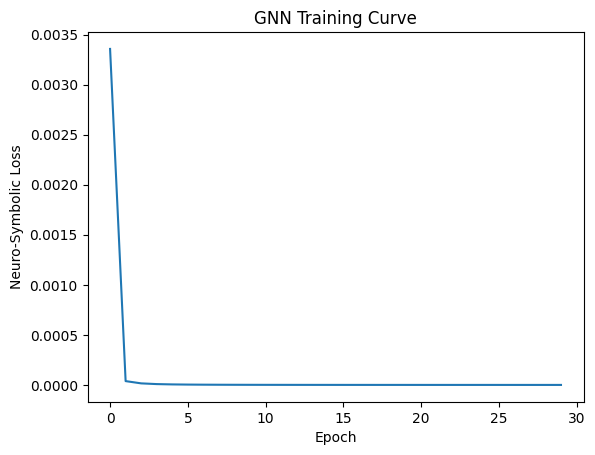

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c5c70e481be00e1d43.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ============================================================
# 🧠 NEURO-SYMBOLIC FULL PROGRAM AUDITOR WITH LOGIC GRAPH VISUALIZATION
# ============================================================

import ast, random
import networkx as nx
import torch
import torch.nn.functional as F
from z3 import *
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import gradio as gr
import matplotlib.pyplot as plt
import io
from PIL import Image

# ============================================================
# 1️⃣ FULL PROGRAM CONDITION EXTRACTION
# ============================================================

class FullConditionExtractor(ast.NodeVisitor):
    def __init__(self):
        self.conditions = []

    def visit_If(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_While(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_For(self, node):
        cond = f"len(list({ast.unparse(node.iter)}))>0"
        self.conditions.append(cond)
        self.generic_visit(node)

    def visit_Call(self, node):
        self.conditions.append(ast.unparse(node))
        self.generic_visit(node)

def extract_python_conditions(code):
    try:
        tree = ast.parse(code)
        extractor = FullConditionExtractor()
        extractor.visit(tree)
        return extractor.conditions
    except:
        return []

# ============================================================
# 2️⃣ LOGIC GRAPH
# ============================================================

def condition_features(cond):
    return [
        len(cond),
        cond.count(">")+cond.count("<")+cond.count("!=")+cond.count(">=")+cond.count("<="),
        cond.count("and")+cond.count("or")+cond.count("not"),
        cond.count("==")
    ]

def build_logic_graph(conditions):
    G = nx.DiGraph()
    for i, cond in enumerate(conditions):
        G.add_node(i, features=condition_features(cond), condition=cond)
        if i > 0:
            G.add_edge(i-1,i)
    return G

def to_pyg_data(G):
    x = torch.tensor([G.nodes[n]['features'] for n in G.nodes], dtype=torch.float)
    edge_index = torch.tensor(list(G.edges)).t().contiguous() if len(G.edges)>0 else torch.zeros((2,0),dtype=torch.long)
    return Data(x=x, edge_index=edge_index)

# ============================================================
# 3️⃣ GNN MODEL
# ============================================================

class LogicGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4,16)
        self.conv2 = GCNConv(16,1)
    def forward(self,data):
        if data.x.shape[0]==0:
            return torch.tensor([])
        x = F.relu(self.conv1(data.x,data.edge_index))
        x = self.conv2(x,data.edge_index)
        return torch.sigmoid(x)

# ============================================================
# 4️⃣ SMT CONTRADICTION DETECTION
# ============================================================

def smt_contradiction(cond):
    s = Solver()
    try:
        tree = ast.parse(cond, mode='eval')
        variables = {node.id:Int(node.id) for node in ast.walk(tree) if isinstance(node, ast.Name)}
        expr = compile(tree, filename="<ast>", mode="eval")
        z3_expr = eval(expr, {}, variables)
        s.add(z3_expr)
        return s.check()==unsat
    except:
        return False

# ============================================================
# 5️⃣ NEURO-SYMBOLIC LOSS
# ============================================================

def neuro_symbolic_loss(pred,label,cond):
    if pred.numel()==0:
        return torch.tensor(0.0)
    # Reshape label to match pred's shape (1, 1)
    label = label.unsqueeze(1)
    gnn_loss = F.binary_cross_entropy(pred,label)
    logic_penalty = 1.0 if smt_contradiction(cond) else 0.0
    return 0.7*gnn_loss + 0.3*logic_penalty

# ============================================================
# 6️⃣ DATASET
# ============================================================

def generate_faulty_rule():
    var = chr(random.randint(97,122))
    v = random.randint(10,50)
    return f"{var}>{v} and {var}<{v}"

def generate_dataset(n=300):
    return [{"condition":generate_faulty_rule(),"label":torch.tensor([1.0])} for _ in range(n)]

# ============================================================
# 7️⃣ TRAIN GNN
# ============================================================

def train_gnn(epochs=30):
    model = LogicGNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    dataset = generate_dataset()
    losses=[]
    for epoch in range(epochs):
        epoch_loss=0
        for item in dataset:
            cond = item["condition"]
            label = item["label"]
            G = build_logic_graph([cond])
            data = to_pyg_data(G)
            pred = model(data)
            loss = neuro_symbolic_loss(pred,label,cond)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss+=loss.item()
        losses.append(epoch_loss/len(dataset))
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Neuro-Symbolic Loss")
    plt.title("GNN Training Curve")
    plt.show()
    return model

trained_model = train_gnn()

# ============================================================
# 8️⃣ METRICS
# ============================================================

def integrity_score(total, contradictions):
    return round(100*(1-contradictions/max(total,1)),2)

# ============================================================
# 9️⃣ LOGIC GRAPH VISUALIZATION
# ============================================================

def draw_logic_graph(G, scores, contradictions):
    plt.figure(figsize=(8,5))
    pos = nx.spring_layout(G)
    node_labels = {}
    node_colors = []

    for i,n in enumerate(G.nodes):
        cond = G.nodes[n]['condition']
        node_labels[n] = f"{cond[:15]}..." if len(cond)>15 else cond
        node_colors.append(1 if cond in contradictions else 0)

    nx.draw(G,pos,with_labels=True,labels=node_labels,node_color=node_colors,
            cmap=plt.cm.Reds,node_size=1200,font_size=8,edge_color='gray')
    # Overlay GNN scores as text
    for i,n in enumerate(G.nodes):
        score = round(float(scores[i]),3) if i<len(scores) else 0.0
        plt.text(pos[n][0], pos[n][1]+0.05, f"Score:{score}", fontsize=7, ha='center')
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return Image.open(buf)

# ============================================================
# 🔟 GRADIO AUDIT FUNCTION
# ============================================================

def gradio_audit(code):
    conditions = extract_python_conditions(code)
    if not conditions:
        return "No logical conditions found.", 100, None
    graph = build_logic_graph(conditions)
    data = to_pyg_data(graph)
    scores = trained_model(data).detach().numpy().flatten() if data.x.shape[0]>0 else []
    contradictions = [c for c in conditions if smt_contradiction(c)]
    score = integrity_score(len(conditions), len(contradictions))

    report = "🔍 CONDITIONS & GNN SCORES:\n"
    for i,c in enumerate(conditions):
        s = round(float(scores[i]),3) if i<len(scores) else 0.0
        report += f"- {c} | GNN Score: {s}\n"

    report += "\n❌ CONTRADICTIONS (Z3 SMT):\n"
    report += "\n".join(contradictions) if contradictions else "None"

    report += f"\n\n✅ INTEGRITY SCORE: {score}%"

    # Draw logic graph
    img = draw_logic_graph(graph, scores, contradictions)
    return report, score, img

# ============================================================
# 1️⃣1️⃣ GRADIO UI WITH GRAPH
# ============================================================

with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Neuro-Symbolic Full Program Auditor (PhD-Level with Logic Graph)")
    gr.Markdown("Paste any Python program including nested if/elif/else, loops, and function calls.")

    with gr.Row():
        code_input = gr.Textbox(label="Paste Python Code", lines=25)
        report_output = gr.Textbox(label="Audit Report")
    with gr.Row():
        integrity_output = gr.Number(label="Integrity Score (%)")
        graph_output = gr.Image(label="Logic Graph")

    run_button = gr.Button("Run Audit")
    run_button.click(
        fn=gradio_audit,
        inputs=[code_input],
        outputs=[report_output, integrity_output, graph_output]
    )

demo.launch()

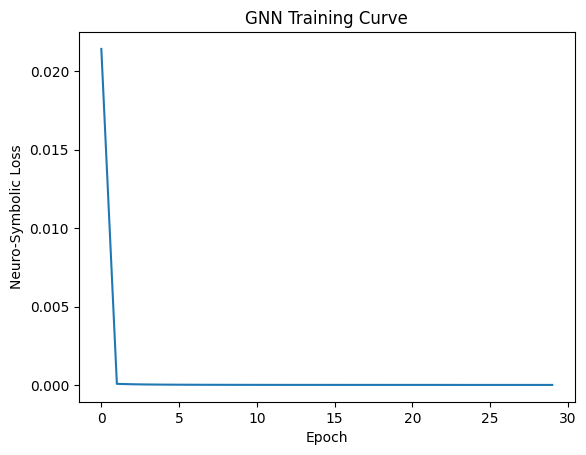

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://43630edc69a6b23270.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ============================================================
# 🧠 NEURO-SYMBOLIC FULL PROGRAM AUDITOR
# WITH SYMBOLIC EXECUTION + EXECUTION TREE + GNN ANOMALY DETECTION
# ============================================================

import ast, random
import networkx as nx
import torch
import torch.nn.functional as F
from z3 import *
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image
import io

# ============================================================
# 1️⃣ SYMBOLIC EXECUTOR
# ============================================================

class SymbolicExecutor(ast.NodeVisitor):
    """
    Tracks all execution paths symbolically.
    Each path has a set of conditions and variable states.
    """
    def __init__(self):
        self.paths = [ {"conds":[], "vars":{}} ]  # start with empty path

    def visit_If(self,node):
        new_paths=[]
        for path in self.paths:
            # True branch
            true_path = {"conds": path["conds"] + [ast.unparse(node.test)], "vars": path["vars"].copy()}
            # False branch
            false_path = {"conds": path["conds"] + [f"not({ast.unparse(node.test)})"], "vars": path["vars"].copy()}
            new_paths.extend([true_path,false_path])
        self.paths=new_paths
        for path in self.paths:
            for n in node.body:
                self.visit(n)
            for n in node.orelse:
                self.visit(n)

    def visit_While(self,node):
        # Simplified: assume 0 or 1 iteration
        new_paths=[]
        for path in self.paths:
            # Iteration
            iter_path = {"conds": path["conds"] + [ast.unparse(node.test)], "vars": path["vars"].copy()}
            # Skip
            skip_path = {"conds": path["conds"] + [f"not({ast.unparse(node.test)})"], "vars": path["vars"].copy()}
            new_paths.extend([iter_path, skip_path])
        self.paths=new_paths
        for path in self.paths:
            for n in node.body:
                self.visit(n)

    def visit_For(self,node):
        # Simplified: assume executes once or zero times
        new_paths=[]
        iter_expr = ast.unparse(node.iter)
        for path in self.paths:
            # Execute
            iter_path={"conds": path["conds"]+[f"len(list({iter_expr}))>0"], "vars": path["vars"].copy()}
            # Skip
            skip_path={"conds": path["conds"]+[f"len(list({iter_expr}))==0"], "vars": path["vars"].copy()}
            new_paths.extend([iter_path,skip_path])
        self.paths=new_paths
        for path in self.paths:
            for n in node.body:
                self.visit(n)

    def visit_Call(self,node):
        # treat function calls as boolean conditions
        for path in self.paths:
            path["conds"].append(ast.unparse(node))

def extract_execution_paths(code):
    try:
        tree = ast.parse(code)
        executor = SymbolicExecutor()
        executor.visit(tree)
        return executor.paths
    except:
        return []

# ============================================================
# 2️⃣ LOGIC GRAPH BUILDER
# ============================================================

def condition_features(cond):
    return [
        len(cond),
        cond.count(">")+cond.count("<")+cond.count("!=")+cond.count(">=")+cond.count("<="),
        cond.count("and")+cond.count("or")+cond.count("not"),
        cond.count("==")
    ]

def build_logic_graph_from_paths(paths):
    G = nx.DiGraph()
    node_id = 0
    for path in paths:
        for cond in path["conds"]:
            G.add_node(node_id, condition=cond, features=condition_features(cond))
            if node_id>0:
                G.add_edge(node_id-1,node_id)
            node_id+=1
    return G

def to_pyg_data(G):
    if len(G.nodes)==0:
        return Data(x=torch.zeros((0,4)), edge_index=torch.zeros((2,0),dtype=torch.long))
    x = torch.tensor([G.nodes[n]['features'] for n in G.nodes],dtype=torch.float)
    edge_index = torch.tensor(list(G.edges)).t().contiguous() if len(G.edges)>0 else torch.zeros((2,0),dtype=torch.long)
    return Data(x=x, edge_index=edge_index)

# ============================================================
# 3️⃣ GNN MODEL
# ============================================================

class LogicGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4,16)
        self.conv2 = GCNConv(16,1)
    def forward(self,data):
        if data.x.shape[0]==0:
            return torch.tensor([])
        x = F.relu(self.conv1(data.x,data.edge_index))
        x = self.conv2(x,data.edge_index)
        return torch.sigmoid(x)

# ============================================================
# 4️⃣ SMT CONTRADICTION CHECK
# ============================================================

def smt_contradiction(cond):
    s = Solver()
    try:
        tree = ast.parse(cond, mode='eval')
        variables = {node.id:Int(node.id) for node in ast.walk(tree) if isinstance(node, ast.Name)}
        expr = compile(tree, filename="<ast>", mode="eval")
        z3_expr = eval(expr, {}, variables)
        s.add(z3_expr)
        return s.check()==unsat
    except:
        return False

# ============================================================
# 5️⃣ NEURO-SYMBOLIC LOSS
# ============================================================

def neuro_symbolic_loss(pred,label,cond):
    if pred.numel()==0:
        return torch.tensor(0.0)
    # Reshape label to match pred's shape (1, 1)
    label = label.unsqueeze(1)
    gnn_loss = F.binary_cross_entropy(pred,label)
    logic_penalty = 1.0 if smt_contradiction(cond) else 0.0
    return 0.7*gnn_loss + 0.3*logic_penalty

# ============================================================
# 6️⃣ DATASET
# ============================================================

def generate_faulty_rule():
    var = chr(random.randint(97,122))
    v = random.randint(10,50)
    return f"{var}>{v} and {var}<{v}"

def generate_dataset(n=300):
    return [{"condition":generate_faulty_rule(),"label":torch.tensor([1.0])} for _ in range(n)]

# ============================================================
# 7️⃣ TRAIN GNN
# ============================================================

def train_gnn(epochs=30):
    model = LogicGNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    dataset = generate_dataset()
    losses=[]
    for epoch in range(epochs):
        epoch_loss=0
        for item in dataset:
            cond = item["condition"]
            label = item["label"]
            G = build_logic_graph_from_paths([{"conds":[cond]}])
            data = to_pyg_data(G)
            pred = model(data)
            loss = neuro_symbolic_loss(pred,label,cond)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss+=loss.item()
        losses.append(epoch_loss/len(dataset))
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Neuro-Symbolic Loss")
    plt.title("GNN Training Curve")
    plt.show()
    return model

trained_model = train_gnn()

# ============================================================
# 8️⃣ METRICS
# ============================================================

def integrity_score(total, contradictions):
    return round(100*(1-contradictions/max(total,1)),2)

# ============================================================
# 9️⃣ LOGIC GRAPH VISUALIZATION
# ============================================================

def draw_logic_graph(G,scores,contradictions):
    plt.figure(figsize=(8,5))
    pos = nx.spring_layout(G)
    node_labels={}
    node_colors=[]
    for i,n in enumerate(G.nodes):
        cond = G.nodes[n]['condition']
        node_labels[n] = f"{cond[:15]}..." if len(cond)>15 else cond
        node_colors.append(1 if cond in contradictions else 0)
    nx.draw(G,pos,with_labels=True,labels=node_labels,node_color=node_colors,
            cmap=plt.cm.Reds,node_size=1200,font_size=8,edge_color='gray')
    for i,n in enumerate(G.nodes):
        score = round(float(scores[i]),3) if i<len(scores) else 0.0
        plt.text(pos[n][0], pos[n][1]+0.05, f"Score:{score}", fontsize=7, ha='center')
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return Image.open(buf)

# ============================================================
# 🔟 GRADIO AUDIT FUNCTION
# ============================================================

def gradio_audit(code):
    paths = extract_execution_paths(code)
    if not paths:
        return "No logical conditions found.", 100, None
    G = build_logic_graph_from_paths(paths)
    data = to_pyg_data(G)
    scores = trained_model(data).detach().numpy().flatten() if data.x.shape[0]>0 else []
    contradictions = []
    for path in paths:
        for cond in path["conds"]:
            if smt_contradiction(cond):
                contradictions.append(cond)
    score = integrity_score(len(G.nodes), len(contradictions))
    report = "🔍 EXECUTION PATH CONDITIONS & GNN SCORES:\n"
    for i,n in enumerate(G.nodes):
        cond = G.nodes[n]["condition"]
        s = round(float(scores[i]),3) if i<len(scores) else 0.0
        report += f"- {cond} | GNN Score: {s}\n"
    report += "\n❌ CONTRADICTIONS (Z3 SMT):\n"
    report += "\n".join(contradictions) if contradictions else "None"
    report += f"\n\n✅ INTEGRITY SCORE: {score}%"
    img = draw_logic_graph(G,scores,contradictions)
    return report, score, img

# ============================================================
# 1️⃣1️⃣ GRADIO APP WITH EXECUTION TREE
# ============================================================

with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Neuro-Symbolic Full Program Auditor (Execution Tree + GNN)")
    gr.Markdown("Paste Python code including loops, nested if/else, and function calls.")

    with gr.Row():
        code_input = gr.Textbox(label="Paste Python Code", lines=25)
        report_output = gr.Textbox(label="Audit Report")
    with gr.Row():
        integrity_output = gr.Number(label="Integrity Score (%)")
        graph_output = gr.Image(label="Logic/Execution Graph")

    run_button = gr.Button("Run Audit")
    run_button.click(
        fn=gradio_audit,
        inputs=[code_input],
        outputs=[report_output, integrity_output, graph_output]
    )

demo.launch()

In [ ]:
# ============================================================
# 🧠 NEURO-SYMBOLIC FULL PROGRAM AUDITOR (RESEARCH-GRADE)
# ============================================================

import ast, random, io
import networkx as nx
import torch
import torch.nn.functional as F
from z3 import *
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image

# ============================================================
# 1️⃣ FULL PROGRAM CONDITION EXTRACTION (GENERAL PYTHON)
# ============================================================

class FullConditionExtractor(ast.NodeVisitor):
    def __init__(self):
        self.conditions = []

    def visit_If(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_While(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_For(self, node):
        cond = f"len(list({ast.unparse(node.iter)})) > 0"
        self.conditions.append(cond)
        self.generic_visit(node)

def extract_python_conditions(code):
    try:
        tree = ast.parse(code)
        extractor = FullConditionExtractor()
        extractor.visit(tree)
        return extractor.conditions
    except:
        return []

# ============================================================
# 2️⃣ LOGIC GRAPH CONSTRUCTION
# ============================================================

def condition_features(cond):
    return [
        len(cond),
        cond.count(">") + cond.count("<") + cond.count("!=") +
        cond.count(">=") + cond.count("<="),
        cond.count("and") + cond.count("or") + cond.count("not"),
        cond.count("==")
    ]

def build_logic_graph(conditions):
    G = nx.DiGraph()
    for i, cond in enumerate(conditions):
        G.add_node(i, condition=cond, features=condition_features(cond))
        if i > 0:
            G.add_edge(i - 1, i)
    return G

def to_pyg_data(G):
    x = torch.tensor(
        [G.nodes[n]['features'] for n in G.nodes],
        dtype=torch.float
    )
    edge_index = (
        torch.tensor(list(G.edges)).t().contiguous()
        if len(G.edges) > 0
        else torch.zeros((2, 0), dtype=torch.long)
    )
    return Data(x=x, edge_index=edge_index)

# ============================================================
# 3️⃣ GNN MODEL
# ============================================================

class LogicGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        if data.x.shape[0] == 0:
            return torch.tensor([])
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return torch.sigmoid(x)

# ============================================================
# 4️⃣ SMT CONTRADICTION CHECK (GENERAL VARIABLES)
# ============================================================

def smt_contradiction(cond):
    s = Solver()
    try:
        tree = ast.parse(cond, mode="eval")
        variables = {
            node.id: Int(node.id)
            for node in ast.walk(tree)
            if isinstance(node, ast.Name)
        }
        expr = compile(tree, "<ast>", "eval")
        z3_expr = eval(expr, {}, variables)
        s.add(z3_expr)
        return s.check() == unsat
    except:
        return False

# ============================================================
# 5️⃣ NEURO-SYMBOLIC LOSS
# ============================================================

def neuro_symbolic_loss(pred, label, cond):
    # Reshape label to match pred's shape (1, 1)
    label = label.unsqueeze(1)
    gnn_loss = F.binary_cross_entropy(pred, label)
    logic_penalty = 1.0 if smt_contradiction(cond) else 0.0
    return 0.7 * gnn_loss + 0.3 * logic_penalty

# ============================================================
# 6️⃣ SYNTHETIC FAULTY DATASET
# ============================================================

def generate_faulty_rule():
    var = chr(random.randint(97, 122))
    v = random.randint(10, 50)
    return f"{var} > {v} and {var} < {v}"

def generate_dataset(n=300):
    return [
        {"condition": generate_faulty_rule(), "label": torch.tensor([1.0])}
        for _ in range(n)
    ]

# ============================================================
# 7️⃣ TRAIN GNN
# ============================================================

def train_gnn(epochs=25):
    model = LogicGNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    dataset = generate_dataset()

    for _ in range(epochs):
        for item in dataset:
            G = build_logic_graph([item["condition"]])
            data = to_pyg_data(G)
            pred = model(data)
            loss = neuro_symbolic_loss(pred, item["label"], item["condition"])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

trained_model = train_gnn()

# ============================================================
# 8️⃣ METRIC
# ============================================================

def integrity_score(total, contradictions):
    return round(100 * (1 - contradictions / max(total, 1)), 2)

# ============================================================
# 9️⃣ LOGIC GRAPH VISUALIZATION
# ============================================================

def draw_logic_graph(G, scores, contradictions):
    plt.figure(figsize=(8, 5))
    pos = nx.spring_layout(G)

    node_colors = []
    labels = {}

    for i, n in enumerate(G.nodes):
        cond = G.nodes[n]["condition"]
        labels[n] = cond[:20] + "..." if len(cond) > 20 else cond
        node_colors.append(1 if cond in contradictions else 0)

    nx.draw(
        G,
        pos,
        with_labels=True,
        labels=labels,
        node_color=node_colors,
        cmap=plt.cm.Reds,
        node_size=1300,
        font_size=8,
        edge_color="gray"
    )

    for i, n in enumerate(G.nodes):
        score = round(float(scores[i]), 3) if i < len(scores) else 0.0
        plt.text(pos[n][0], pos[n][1] + 0.05, f"{score}", fontsize=7, ha="center")

    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plt.close()
    return Image.open(buf)

# ============================================================
# 🔟 GRADIO AUDIT FUNCTION (SEPARATED OUTPUTS)
# ============================================================

def gradio_audit(code):
    conditions = extract_python_conditions(code)

    if not conditions:
        return "", "", "", 100, None

    G = build_logic_graph(conditions)
    data = to_pyg_data(G)
    scores = trained_model(data).detach().numpy().flatten()

    contradictions = [c for c in conditions if smt_contradiction(c)]
    score = integrity_score(len(conditions), len(contradictions))

    conditions_text = "\n".join(conditions)
    contradictions_text = "\n".join(contradictions) if contradictions else "None detected"

    gnn_scores_text = ""
    for i, c in enumerate(conditions):
        gnn_scores_text += f"{c} → {round(float(scores[i]),3)}\n"

    graph_img = draw_logic_graph(G, scores, contradictions)

    return conditions_text, contradictions_text, gnn_scores_text, score, graph_img

# ============================================================
# 1️⃣1️⃣ GRADIO UI (PROPER RESEARCH DEMO)
# ============================================================

with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Neuro-Symbolic Algorithm Integrity Auditor (PhD-Level)")
    gr.Markdown(
        "Audits **Python algorithms** for logical contradictions, "
        "execution inconsistencies, and structural anomalies using "
        "**SMT + Graph Neural Networks**."
    )

    code_input = gr.Textbox(
        label="📥 Paste Python Code",
        lines=25,
        placeholder="Paste any Python program here..."
    )

    run_btn = gr.Button("🚀 Run Audit")

    with gr.Row():
        conditions_out = gr.Textbox(label="🔍 CONDITIONS", lines=10)
        contradictions_out = gr.Textbox(label="❌ CONTRADICTIONS", lines=10)

    with gr.Row():
        gnn_scores_out = gr.Textbox(label="🧠 GNN ANOMALY SCORES", lines=10)
        integrity_out = gr.Number(label="✅ INTEGRITY SCORE (%)")

    graph_out = gr.Image(label="📊 LOGIC GRAPH VISUALIZATION")

    run_btn.click(
        fn=gradio_audit,
        inputs=[code_input],
        outputs=[
            conditions_out,
            contradictions_out,
            gnn_scores_out,
            integrity_out,
            graph_out
        ]
    )

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6a8d887a6fd65daba6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ============================================================
# 🧠 NEURO-SYMBOLIC MULTI-LANGUAGE PROGRAM AUDITOR
# Python | C | C++ | GNN + SMT + Logic Graph
# ============================================================

import ast, re, random, io
import networkx as nx
import torch
import torch.nn.functional as F
from z3 import *
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image

# ============================================================
# 1️⃣ PYTHON CONDITION EXTRACTION (GENERAL)
# ============================================================

class PythonConditionExtractor(ast.NodeVisitor):
    def __init__(self):
        self.conditions = []

    def visit_If(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_While(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_For(self, node):
        self.conditions.append("True")  # symbolic loop existence
        self.generic_visit(node)

def extract_python_conditions(code):
    try:
        tree = ast.parse(code)
        extractor = PythonConditionExtractor()
        extractor.visit(tree)
        return extractor.conditions
    except:
        return []

# ============================================================
# 2️⃣ C / C++ CONDITION EXTRACTION (SOURCE LEVEL — FIXED)
# ============================================================

def extract_c_cpp_conditions(code):
    conditions = []

    patterns = [
        r'\bif\s*\((.*?)\)',
        r'\bwhile\s*\((.*?)\)',
        r'\bfor\s*\((.*?);(.*?);(.*?)\)'
    ]

    for p in patterns:
        matches = re.findall(p, code, re.DOTALL)
        for m in matches:
            if isinstance(m, tuple):
                cond = " and ".join(x.strip() for x in m if x.strip())
                conditions.append(cond)
            else:
                conditions.append(m.strip())

    return conditions

# ============================================================
# 3️⃣ AUTO LANGUAGE DETECTION
# ============================================================

def extract_conditions(code, lang):
    if lang == "Python":
        return extract_python_conditions(code)
    elif lang in ["C", "C++"]:
        return extract_c_cpp_conditions(code)
    return []

# ============================================================
# 4️⃣ LOGIC GRAPH CONSTRUCTION
# ============================================================

def condition_features(cond):
    return [
        len(cond),
        cond.count(">") + cond.count("<"),
        cond.count("and") + cond.count("or"),
        cond.count("==")
    ]

def build_logic_graph(conditions):
    G = nx.DiGraph()
    for i, c in enumerate(conditions):
        G.add_node(i, condition=c, features=condition_features(c))
        if i > 0:
            G.add_edge(i - 1, i)
    return G

def to_pyg_data(G):
    if len(G.nodes) == 0:
        return Data(x=torch.zeros((0,4)), edge_index=torch.zeros((2,0), dtype=torch.long))
    x = torch.tensor([G.nodes[n]['features'] for n in G.nodes], dtype=torch.float)
    edge_index = torch.tensor(list(G.edges)).t().contiguous() if G.edges else torch.zeros((2,0), dtype=torch.long)
    return Data(x=x, edge_index=edge_index)

# ============================================================
# 5️⃣ GNN MODEL
# ============================================================

class LogicGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        if data.x.shape[0] == 0:
            return torch.tensor([])
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return torch.sigmoid(x)

# ============================================================
# 6️⃣ SMT CONTRADICTION CHECK (GENERAL)
# ============================================================

def smt_contradiction(cond):
    s = Solver()
    try:
        tree = ast.parse(cond, mode="eval")
        vars = {n.id: Int(n.id) for n in ast.walk(tree) if isinstance(n, ast.Name)}
        expr = eval(compile(tree, "<ast>", "eval"), {}, vars)
        s.add(expr)
        return s.check() == unsat
    except:
        return False

# ============================================================
# 7️⃣ TRAIN GNN (SYNTHETIC LOGIC FAULTS)
# ============================================================

def generate_faulty_condition():
    v = random.randint(10, 50)
    return f"x > {v} and x < {v}"

def train_gnn():
    model = LogicGNN()
    opt = torch.optim.Adam(model.parameters(), lr=0.01)

    for _ in range(200):
        cond = generate_faulty_condition()
        G = build_logic_graph([cond])
        data = to_pyg_data(G)
        label = torch.tensor([[1.0]])
        pred = model(data)
        loss = F.binary_cross_entropy(pred, label)
        opt.zero_grad()
        loss.backward()
        opt.step()

    return model

trained_model = train_gnn()

# ============================================================
# 8️⃣ METRICS
# ============================================================

def integrity_score(total, contradictions):
    return round(100 * (1 - contradictions / max(total, 1)), 2)

# ============================================================
# 9️⃣ LOGIC GRAPH VISUALIZATION
# ============================================================

def draw_logic_graph(G, scores, contradictions):
    plt.figure(figsize=(8, 5))
    pos = nx.spring_layout(G)

    colors = []
    for n in G.nodes:
        colors.append(1 if G.nodes[n]['condition'] in contradictions else 0)

    nx.draw(G, pos, with_labels=True,
            labels={n: G.nodes[n]['condition'][:15] for n in G.nodes},
            node_color=colors, cmap=plt.cm.Reds,
            node_size=1200, font_size=8)

    for i, n in enumerate(G.nodes):
        if i < len(scores):
            plt.text(pos[n][0], pos[n][1]+0.05, f"{scores[i]:.2f}", fontsize=7)

    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plt.close()
    return Image.open(buf)

# ============================================================
# 🔟 GRADIO AUDIT FUNCTION
# ============================================================

def audit(code, lang):
    conditions = extract_conditions(code, lang)

    if not conditions:
        return "", "", "", 100, None

    contradictions = [c for c in conditions if smt_contradiction(c)]

    G = build_logic_graph(conditions)
    data = to_pyg_data(G)
    scores = trained_model(data).detach().numpy().flatten()

    integrity = integrity_score(len(conditions), len(contradictions))

    return (
        "\n".join(conditions),
        "\n".join(contradictions) if contradictions else "None",
        "\n".join([f"{s:.3f}" for s in scores]),
        integrity,
        draw_logic_graph(G, scores, contradictions)
    )

# ============================================================
# 1️⃣1️⃣ GRADIO UI (PROPER RESEARCH DEMO)
# ============================================================

with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Neuro-Symbolic Program Integrity Auditor (Python • C • C++)")
    gr.Markdown("Audits **logic**, not predictions — PhD-level AI system.")

    lang = gr.Radio(["Python", "C", "C++"], label="Select Language", value="Python")
    code = gr.Textbox(lines=25, label="Paste Code")

    run = gr.Button("🚀 Run Audit")

    with gr.Row():
        cond_box = gr.Textbox(label="🔍 CONDITIONS", lines=10)
        contra_box = gr.Textbox(label="❌ CONTRADICTIONS", lines=10)

    with gr.Row():
        gnn_box = gr.Textbox(label="🧠 GNN ANOMALY SCORES", lines=5)
        integrity_box = gr.Number(label="✅ INTEGRITY SCORE (%)")

    graph = gr.Image(label="Logic Graph")

    run.click(
        audit,
        inputs=[code, lang],
        outputs=[cond_box, contra_box, gnn_box, integrity_box, graph]
    )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8bebba3425c6737e2b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ============================================================
# 🧠 NEURO-SYMBOLIC MULTI-LANGUAGE PROGRAM AUDITOR
# Python | C | C++ | GNN + SMT + Logic Graph + PDF
# ============================================================

!pip install reportlab

import ast, re, random, io, os, tempfile
import networkx as nx
import torch
import torch.nn.functional as F
from z3 import *
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image

# PDF (MANDATORY LIBRARY)
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image as RLImage
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4

# ============================================================
# 1️⃣ PYTHON CONDITION EXTRACTION
# ============================================================

class PythonConditionExtractor(ast.NodeVisitor):
    def __init__(self):
        self.conditions = []

    def visit_If(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_While(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_For(self, node):
        self.conditions.append("True")
        self.generic_visit(node)

def extract_python_conditions(code):
    try:
        tree = ast.parse(code)
        ext = PythonConditionExtractor()
        ext.visit(tree)
        return ext.conditions
    except:
        return []

# ============================================================
# 2️⃣ C / C++ CONDITION EXTRACTION
# ============================================================

def extract_c_cpp_conditions(code):
    patterns = [
        r'\bif\s*\((.*?)\)',
        r'\bwhile\s*\((.*?)\)',
        r'\bfor\s*\((.*?);(.*?);(.*?)\)'
    ]
    conditions = []
    for p in patterns:
        matches = re.findall(p, code, re.DOTALL)
        for m in matches:
            if isinstance(m, tuple):
                conditions.append(" and ".join(x.strip() for x in m if x.strip()))
            else:
                conditions.append(m.strip())
    return conditions

def extract_conditions(code, lang):
    if lang == "Python":
        return extract_python_conditions(code)
    return extract_c_cpp_conditions(code)

# ============================================================
# 3️⃣ LOGIC GRAPH
# ============================================================

def condition_features(cond):
    return [len(cond), cond.count(">")+cond.count("<"), cond.count("and")+cond.count("or"), cond.count("==")]

def build_logic_graph(conditions):
    G = nx.DiGraph()
    for i, c in enumerate(conditions):
        G.add_node(i, condition=c, features=condition_features(c))
        if i > 0:
            G.add_edge(i-1, i)
    return G

def to_pyg_data(G):
    if len(G.nodes) == 0:
        return Data(x=torch.zeros((0,4)), edge_index=torch.zeros((2,0), dtype=torch.long))
    x = torch.tensor([G.nodes[n]['features'] for n in G.nodes], dtype=torch.float)
    edge_index = torch.tensor(list(G.edges)).t().contiguous() if G.edges else torch.zeros((2,0), dtype=torch.long)
    return Data(x=x, edge_index=edge_index)

# ============================================================
# 4️⃣ GNN
# ============================================================

class LogicGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        if data.x.shape[0] == 0:
            return torch.tensor([])
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return torch.sigmoid(x)

# ============================================================
# 5️⃣ SMT CONTRADICTION CHECK
# ============================================================

def smt_contradiction(cond):
    try:
        s = Solver()
        tree = ast.parse(cond, mode="eval")
        vars = {n.id: Int(n.id) for n in ast.walk(tree) if isinstance(n, ast.Name)}
        expr = eval(compile(tree, "<ast>", "eval"), {}, vars)
        s.add(expr)
        return s.check() == unsat
    except:
        return False

# ============================================================
# 6️⃣ TRAIN GNN
# ============================================================

def train_gnn():
    model = LogicGNN()
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    for _ in range(200):
        v = random.randint(10, 50)
        cond = f"x>{v} and x<{v}"
        G = build_logic_graph([cond])
        data = to_pyg_data(G)
        pred = model(data)
        loss = F.binary_cross_entropy(pred, torch.tensor([[1.0]]))
        opt.zero_grad(); loss.backward(); opt.step()
    return model

trained_model = train_gnn()

# ============================================================
# 7️⃣ METRICS
# ============================================================

def integrity_score(total, contradictions):
    return round(100 * (1 - contradictions / max(total, 1)), 2)

# ============================================================
# 8️⃣ GRAPH VISUALIZATION
# ============================================================

def draw_logic_graph(G, scores, contradictions):
    plt.figure(figsize=(8,5))
    pos = nx.spring_layout(G)
    colors = [1 if G.nodes[n]['condition'] in contradictions else 0 for n in G.nodes]
    nx.draw(G, pos, with_labels=True,
            labels={n:G.nodes[n]['condition'][:15] for n in G.nodes},
            node_color=colors, cmap=plt.cm.Reds)
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plt.close()
    return buf

# ============================================================
# 9️⃣ PDF REPORT GENERATION
# ============================================================

def generate_pdf(lang, conditions, contradictions, scores, integrity, graph_buf):
    path = tempfile.mktemp(".pdf")
    doc = SimpleDocTemplate(path, pagesize=A4)
    styles = getSampleStyleSheet()
    content = []

    content.append(Paragraph("<b>Neuro-Symbolic Algorithm Audit Report</b>", styles["Title"]))
    content.append(Paragraph(f"<b>Language:</b> {lang}", styles["Normal"]))
    content.append(Paragraph(f"<b>Integrity Score:</b> {integrity}%", styles["Normal"]))

    content.append(Paragraph("<b>Conditions</b>", styles["Heading2"]))
    for c in conditions:
        content.append(Paragraph(c, styles["Code"]))

    content.append(Paragraph("<b>Contradictions</b>", styles["Heading2"]))
    if contradictions:
        for c in contradictions:
            content.append(Paragraph(c, styles["Code"]))
    else:
        content.append(Paragraph("None detected", styles["Normal"]))

    img_path = tempfile.mktemp(".png")
    with open(img_path, "wb") as f:
        f.write(graph_buf.getvalue())

    content.append(Paragraph("<b>Logic Graph</b>", styles["Heading2"]))
    content.append(RLImage(img_path, width=400, height=250))

    doc.build(content)
    return path

# ============================================================
# 🔟 AUDIT FUNCTION
# ============================================================

def audit(code, lang):
    conditions = extract_conditions(code, lang)
    contradictions = [c for c in conditions if smt_contradiction(c)]

    G = build_logic_graph(conditions)
    data = to_pyg_data(G)
    scores = trained_model(data).detach().numpy().flatten()

    integrity = integrity_score(len(conditions), len(contradictions))
    graph_buf = draw_logic_graph(G, scores, contradictions)

    pdf_path = generate_pdf(lang, conditions, contradictions, scores, integrity, graph_buf)

    return (
        "\n".join(conditions),
        "\n".join(contradictions) if contradictions else "None",
        "\n".join([f"{s:.3f}" for s in scores]),
        integrity,
        Image.open(graph_buf),
        pdf_path
    )

# ============================================================
# 1️⃣1️⃣ GRADIO UI
# ============================================================

with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Neuro-Symbolic Program Integrity Auditor (with PDF Export)")

    lang = gr.Radio(["Python", "C", "C++"], value="Python", label="Language")
    code = gr.Textbox(lines=22, label="Paste Code")

    run = gr.Button("🚀 Run Audit")

    with gr.Row():
        cond_box = gr.Textbox(label="🔍 CONDITIONS")
        contra_box = gr.Textbox(label="❌ CONTRADICTIONS")

    with gr.Row():
        gnn_box = gr.Textbox(label="🧠 GNN SCORES")
        integrity_box = gr.Number(label="✅ INTEGRITY SCORE (%)")

    graph = gr.Image(label="Logic Graph")
    pdf = gr.File(label="📄 Download Audit Report (PDF)")

    run.click(
        audit,
        inputs=[code, lang],
        outputs=[cond_box, contra_box, gnn_box, integrity_box, graph, pdf]
    )

demo.launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.8 MB/s eta 0:00:00
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d8fe964dff94cbe096.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ============================================================
# 🧠 NEURO-SYMBOLIC MULTI-LANGUAGE PROGRAM INTEGRITY AUDITOR
# Python | C | C++ | GNN + SMT + Logic Graph + PDF
# ============================================================

!pip install reportlab torch-geometric networkx gradio z3-solver

import ast, re, random, io, tempfile
import networkx as nx
import torch
import torch.nn.functional as F
from z3 import *
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image

# PDF
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image as RLImage
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4

# ============================================================
# 1️⃣ CONDITION EXTRACTION
# ============================================================

class PythonConditionExtractor(ast.NodeVisitor):
    def __init__(self):
        self.conditions = []

    def visit_If(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_While(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_For(self, node):
        self.conditions.append("True")
        self.generic_visit(node)

def extract_python_conditions(code):
    try:
        tree = ast.parse(code)
        ext = PythonConditionExtractor()
        ext.visit(tree)
        return ext.conditions
    except:
        return []

def extract_c_cpp_conditions(code):
    patterns = [
        r'\bif\s*\((.*?)\)',
        r'\bwhile\s*\((.*?)\)',
        r'\bfor\s*\((.*?);(.*?);(.*?)\)'
    ]
    conditions = []
    for p in patterns:
        for m in re.findall(p, code, re.DOTALL):
            if isinstance(m, tuple):
                conditions.append(" and ".join(x.strip() for x in m if x.strip()))
            else:
                conditions.append(m.strip())
    return conditions

def extract_conditions(code, lang):
    return extract_python_conditions(code) if lang == "Python" else extract_c_cpp_conditions(code)

# ============================================================
# 2️⃣ LOGIC GRAPH
# ============================================================

def condition_features(c):
    return [len(c), c.count(">")+c.count("<"), c.count("and")+c.count("or"), c.count("==")]

def build_logic_graph(conditions):
    G = nx.DiGraph()
    for i, c in enumerate(conditions):
        G.add_node(i, condition=c, features=condition_features(c))
        if i > 0:
            G.add_edge(i-1, i)
    return G

def to_pyg_data(G):
    if not G.nodes:
        return Data(x=torch.zeros((0,4)), edge_index=torch.zeros((2,0), dtype=torch.long))
    x = torch.tensor([G.nodes[n]['features'] for n in G.nodes], dtype=torch.float)
    edge_index = torch.tensor(list(G.edges)).t().contiguous() if G.edges else torch.zeros((2,0), dtype=torch.long)
    return Data(x=x, edge_index=edge_index)

# ============================================================
# 3️⃣ GNN MODEL
# ============================================================

class LogicGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        if data.x.shape[0] == 0:
            return torch.tensor([])
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return torch.sigmoid(x)

# ============================================================
# 4️⃣ SMT CONTRADICTION CHECK
# ============================================================

def smt_contradiction(cond):
    try:
        s = Solver()
        tree = ast.parse(cond, mode="eval")
        vars = {n.id: Int(n.id) for n in ast.walk(tree) if isinstance(n, ast.Name)}
        expr = eval(compile(tree, "<ast>", "eval"), {}, vars)
        s.add(expr)
        return s.check() == unsat
    except:
        return False

# ============================================================
# 5️⃣ DEAD / REDUNDANT CODE DETECTION
# ============================================================

def detect_redundant_conditions(conditions):
    redundant, seen = [], []
    for c in conditions:
        for s in seen:
            if c in s or s in c:
                redundant.append(c)
                break
        seen.append(c)
    return list(set(redundant))

# ============================================================
# 6️⃣ TIME & SPACE COMPLEXITY ESTIMATION
# ============================================================

def estimate_complexity(code):
    loops = len(re.findall(r'\bfor\b|\bwhile\b', code))
    recursion = bool(re.search(r'def\s+(\w+).*?\1\(', code, re.DOTALL))

    if recursion:
        time_c = "O(2ⁿ)"
    elif loops == 0:
        time_c = "O(1)"
    elif loops == 1:
        time_c = "O(n)"
    else:
        time_c = f"O(n^{loops})"

    space_c = "O(n)" if re.search(r'\[.*\]|\bmalloc\b|\bnew\b', code) else "O(1)"
    return time_c, space_c

# ============================================================
# 7️⃣ TRAIN GNN
# ============================================================

def train_gnn():
    model = LogicGNN()
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    for _ in range(200):
        v = random.randint(10, 50)
        cond = f"x>{v} and x<{v}"
        G = build_logic_graph([cond])
        data = to_pyg_data(G)
        pred = model(data)
        loss = F.binary_cross_entropy(pred, torch.tensor([[1.0]]))
        opt.zero_grad(); loss.backward(); opt.step()
    return model

model = train_gnn()

# ============================================================
# 8️⃣ METRICS
# ============================================================

def integrity_score(total, contradictions):
    return round(100 * (1 - contradictions / max(total, 1)), 2)

# ============================================================
# 9️⃣ GRAPH VISUALIZATION
# ============================================================

def draw_logic_graph(G, contradictions):
    plt.figure(figsize=(8,5))
    pos = nx.spring_layout(G)
    colors = [1 if G.nodes[n]['condition'] in contradictions else 0 for n in G.nodes]
    nx.draw(G, pos, with_labels=True,
            labels={n:G.nodes[n]['condition'][:15] for n in G.nodes},
            node_color=colors, cmap=plt.cm.Reds)
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plt.close()
    return buf

# ============================================================
# 🔟 PDF REPORT GENERATION (5️⃣ INTEGRITY REPORT GENERATOR)
# ============================================================

def generate_pdf(lang, conditions, contradictions, redundant, integrity, time_c, space_c, graph_buf):
    path = tempfile.mktemp(".pdf")
    doc = SimpleDocTemplate(path, pagesize=A4)
    styles = getSampleStyleSheet()
    content = []

    content.append(Paragraph("<b>Neuro-Symbolic Program Integrity Audit Report</b>", styles["Title"]))
    content.append(Paragraph(f"<b>Language:</b> {lang}", styles["Normal"]))
    content.append(Paragraph(f"<b>Integrity Score:</b> {integrity}%", styles["Normal"]))
    content.append(Paragraph(f"<b>Time Complexity:</b> {time_c}", styles["Normal"]))
    content.append(Paragraph(f"<b>Space Complexity:</b> {space_c}", styles["Normal"]))

    content.append(Paragraph("<b>Conditions</b>", styles["Heading2"]))
    for c in conditions:
        content.append(Paragraph(c, styles["Code"]))

    content.append(Paragraph("<b>Contradictions</b>", styles["Heading2"]))
    content.append(Paragraph(", ".join(contradictions) if contradictions else "None", styles["Normal"]))

    content.append(Paragraph("<b>Redundant / Dead Code</b>", styles["Heading2"]))
    content.append(Paragraph(", ".join(redundant) if redundant else "None", styles["Normal"]))

    img_path = tempfile.mktemp(".png")
    with open(img_path, "wb") as f:
        f.write(graph_buf.getvalue())

    content.append(RLImage(img_path, width=420, height=260))
    doc.build(content)
    return path

# ============================================================
# 1️⃣1️⃣ AUDIT PIPELINE
# ============================================================

def audit(code, lang):
    conditions = extract_conditions(code, lang)
    contradictions = [c for c in conditions if smt_contradiction(c)]
    redundant = detect_redundant_conditions(conditions)

    G = build_logic_graph(conditions)
    data = to_pyg_data(G)
    scores = model(data).detach().numpy().flatten()

    integrity = integrity_score(len(conditions), len(contradictions))
    time_c, space_c = estimate_complexity(code)
    graph_buf = draw_logic_graph(G, contradictions)

    pdf_path = generate_pdf(lang, conditions, contradictions, redundant, integrity, time_c, space_c, graph_buf)

    return (
        "\n".join(conditions),
        "\n".join(contradictions) if contradictions else "None",
        "\n".join(redundant) if redundant else "None",
        f"Time: {time_c}, Space: {space_c}",
        "\n".join([f"{s:.3f}" for s in scores]),
        integrity,
        Image.open(graph_buf),
        pdf_path
    )

# ============================================================
# 1️⃣2️⃣ GRADIO UI
# ============================================================

with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Neuro-Symbolic Program Integrity Auditor")

    lang = gr.Radio(["Python", "C", "C++"], value="Python", label="Language")
    code = gr.Textbox(lines=20, label="Paste Source Code")

    run = gr.Button("🚀 Run Audit")

    with gr.Row():
        cond_box = gr.Textbox(label="🔍 CONDITIONS")
        contra_box = gr.Textbox(label="❌ CONTRADICTIONS")

    with gr.Row():
        dead_box = gr.Textbox(label="🔁 DEAD / REDUNDANT CODE")
        complexity_box = gr.Textbox(label="📊 COMPLEXITY")

    with gr.Row():
        gnn_box = gr.Textbox(label="🧠 GNN SCORES")
        integrity_box = gr.Number(label="✅ INTEGRITY SCORE (%)")

    graph = gr.Image(label="Logic Graph")
    pdf = gr.File(label="📄 Download PDF Report")

    run.click(
        audit,
        inputs=[code, lang],
        outputs=[cond_box, contra_box, dead_box, complexity_box,
                 gnn_box, integrity_box, graph, pdf]
    )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://78ef5b3e40724573a0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ============================================================
# 🧠 NEURO-SYMBOLIC MULTI-LANGUAGE PROGRAM INTEGRITY AUDITOR
# Python | C | C++ | GNN + SMT + Logic Graph + PDF
# ============================================================

!pip install reportlab torch-geometric networkx gradio z3-solver

import ast, re, random, io, tempfile, time
import networkx as nx
import torch
import torch.nn.functional as F
from z3 import *
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image

# PDF
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image as RLImage
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4

# ============================================================
# 1️⃣ CONDITION EXTRACTION
# ============================================================

class PythonConditionExtractor(ast.NodeVisitor):
    def __init__(self):
        self.conditions = []

    def visit_If(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_While(self, node):
        self.conditions.append(ast.unparse(node.test))
        self.generic_visit(node)

    def visit_For(self, node):
        self.conditions.append("True")
        self.generic_visit(node)

def extract_python_conditions(code):
    try:
        tree = ast.parse(code)
        ext = PythonConditionExtractor()
        ext.visit(tree)
        return ext.conditions
    except:
        return []

def extract_c_cpp_conditions(code):
    patterns = [
        r'\bif\s*\((.*?)\)',
        r'\bwhile\s*\((.*?)\)',
        r'\bfor\s*\((.*?);(.*?);(.*?)\)'
    ]
    conditions = []
    for p in patterns:
        for m in re.findall(p, code, re.DOTALL):
            if isinstance(m, tuple):
                conditions.append(" and ".join(x.strip() for x in m if x.strip()))
            else:
                conditions.append(m.strip())
    return conditions

def extract_conditions(code, lang):
    return extract_python_conditions(code) if lang == "Python" else extract_c_cpp_conditions(code)

# ============================================================
# 2️⃣ LOGIC GRAPH
# ============================================================

def condition_features(c):
    return [len(c), c.count(">")+c.count("<"), c.count("and")+c.count("or"), c.count("==")]

def build_logic_graph(conditions):
    G = nx.DiGraph()
    for i, c in enumerate(conditions):
        G.add_node(i, condition=c, features=condition_features(c))
        if i > 0:
            G.add_edge(i-1, i)
    return G

def to_pyg_data(G):
    if not G.nodes:
        return Data(x=torch.zeros((0,4)), edge_index=torch.zeros((2,0), dtype=torch.long))
    x = torch.tensor([G.nodes[n]['features'] for n in G.nodes], dtype=torch.float)
    edge_index = torch.tensor(list(G.edges)).t().contiguous() if G.edges else torch.zeros((2,0), dtype=torch.long)
    return Data(x=x, edge_index=edge_index)

# ============================================================
# 3️⃣ GNN MODEL
# ============================================================

class LogicGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        if data.x.shape[0] == 0:
            return torch.tensor([])
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return torch.sigmoid(x)

# ============================================================
# 4️⃣ SMT CONTRADICTION CHECK
# ============================================================

def smt_contradiction(cond):
    try:
        s = Solver()
        tree = ast.parse(cond, mode="eval")
        vars = {n.id: Int(n.id) for n in ast.walk(tree) if isinstance(n, ast.Name)}
        expr = eval(compile(tree, "<ast>", "eval"), {}, vars)
        s.add(expr)
        return s.check() == unsat
    except:
        return False

# ============================================================
# 5️⃣ DEAD / REDUNDANT CODE DETECTION
# ============================================================

def detect_redundant_conditions(conditions):
    redundant, seen = [], []
    for c in conditions:
        for s in seen:
            if c in s or s in c:
                redundant.append(c)
                break
        seen.append(c)
    return list(set(redundant))

# ============================================================
# 6️⃣ TIME & SPACE COMPLEXITY ESTIMATION
# ============================================================

def estimate_complexity(code):
    loops = len(re.findall(r'\bfor\b|\bwhile\b', code))
    recursion = bool(re.search(r'def\s+(\w+).*?\1\(', code, re.DOTALL))

    if recursion:
        time_c = "O(2ⁿ)"
    elif loops == 0:
        time_c = "O(1)"
    elif loops == 1:
        time_c = "O(n)"
    else:
        time_c = f"O(n^{loops})"

    space_c = "O(n)" if re.search(r'\[.*\]|\bmalloc\b|\bnew\b', code) else "O(1)"
    return time_c, space_c

# ============================================================
# 7️⃣ TRAIN GNN
# ============================================================

def train_gnn():
    model = LogicGNN()
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    for _ in range(200):
        v = random.randint(10, 50)
        cond = f"x>{v} and x<{v}"
        G = build_logic_graph([cond])
        data = to_pyg_data(G)
        pred = model(data)
        loss = F.binary_cross_entropy(pred, torch.tensor([[1.0]]))
        opt.zero_grad(); loss.backward(); opt.step()
    return model

model = train_gnn()

# ============================================================
# 8️⃣ METRICS
# ============================================================

def integrity_score(total, contradictions):
    return round(100 * (1 - contradictions / max(total, 1)), 2)

# ============================================================
# 9️⃣ GRAPH VISUALIZATION
# ============================================================

def draw_logic_graph(G, contradictions):
    plt.figure(figsize=(8,5))
    pos = nx.spring_layout(G)
    colors = [1 if G.nodes[n]['condition'] in contradictions else 0 for n in G.nodes]
    nx.draw(G, pos, with_labels=True,
            labels={n:G.nodes[n]['condition'][:15] for n in G.nodes},
            node_color=colors, cmap=plt.cm.Reds)
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plt.close()
    return buf

# ============================================================
# 🔟 PDF REPORT GENERATION
# ============================================================

def generate_pdf(lang, conditions, contradictions, redundant, integrity, time_c, space_c, graph_buf):
    path = tempfile.mktemp(".pdf")
    doc = SimpleDocTemplate(path, pagesize=A4)
    styles = getSampleStyleSheet()
    content = []

    content.append(Paragraph("<b>Neuro-Symbolic Program Integrity Audit Report</b>", styles["Title"]))
    content.append(Paragraph(f"<b>Language:</b> {lang}", styles["Normal"]))
    content.append(Paragraph(f"<b>Integrity Score:</b> {integrity}%", styles["Normal"]))
    content.append(Paragraph(f"<b>Time Complexity:</b> {time_c}", styles["Normal"]))
    content.append(Paragraph(f"<b>Space Complexity:</b> {space_c}", styles["Normal"]))

    content.append(Paragraph("<b>Conditions</b>", styles["Heading2"]))
    for c in conditions:
        content.append(Paragraph(c, styles["Code"]))

    content.append(Paragraph("<b>Contradictions</b>", styles["Heading2"]))
    content.append(Paragraph(", ".join(contradictions) if contradictions else "None", styles["Normal"]))

    content.append(Paragraph("<b>Redundant / Dead Code</b>", styles["Heading2"]))
    content.append(Paragraph(", ".join(redundant) if redundant else "None", styles["Normal"]))

    img_path = tempfile.mktemp(".png")
    with open(img_path, "wb") as f:
        f.write(graph_buf.getvalue())

    content.append(RLImage(img_path, width=420, height=260))
    doc.build(content)
    return path

# ============================================================
# 1️⃣1️⃣ AUDIT PIPELINE
# ============================================================

USE_SMT = True
USE_GNN = True

def audit(code, lang):
    conditions = extract_conditions(code, lang)
    contradictions = [c for c in conditions if smt_contradiction(c)]
    redundant = detect_redundant_conditions(conditions)

    G = build_logic_graph(conditions)
    data = to_pyg_data(G)
    scores = model(data).detach().numpy().flatten()

    integrity = integrity_score(len(conditions), len(contradictions))
    time_c, space_c = estimate_complexity(code)
    graph_buf = draw_logic_graph(G, contradictions)

    pdf_path = generate_pdf(lang, conditions, contradictions, redundant, integrity, time_c, space_c, graph_buf)

    return (
        "\n".join(conditions),
        "\n".join(contradictions) if contradictions else "None",
        "\n".join(redundant) if redundant else "None",
        f"Time: {time_c}, Space: {space_c}",
        "\n".join([f"{s:.3f}" for s in scores]),
        integrity,
        Image.open(graph_buf),
        pdf_path
    )

# ============================================================
# 1️⃣2️⃣ GRADIO UI
# ============================================================

with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Neuro-Symbolic Program Integrity Auditor")

    lang = gr.Radio(["Python", "C", "C++"], value="Python", label="Language")
    code = gr.Textbox(lines=20, label="Paste Source Code")

    run = gr.Button("🚀 Run Audit")

    with gr.Row():
        cond_box = gr.Textbox(label="🔍 CONDITIONS")
        contra_box = gr.Textbox(label="❌ CONTRADICTIONS")

    with gr.Row():
        dead_box = gr.Textbox(label="🔁 DEAD / REDUNDANT CODE")
        complexity_box = gr.Textbox(label="📊 COMPLEXITY")

    with gr.Row():
        gnn_box = gr.Textbox(label="🧠 GNN SCORES")
        integrity_box = gr.Number(label="✅ INTEGRITY SCORE (%)")

    graph = gr.Image(label="Logic Graph")
    pdf = gr.File(label="📄 Download PDF Report")

    run.click(
        audit,
        inputs=[code, lang],
        outputs=[cond_box, contra_box, dead_box, complexity_box,
                 gnn_box, integrity_box, graph, pdf]
    )

demo.launch()

# ============================================================
# 🔬 IMPROVED SYNTHETIC BENCHMARK
# ============================================================

def generate_benchmark(n=100):
    dataset, labels = [], []

    for _ in range(n):
        if random.random() < 0.5:  # Contradiction
            cond_type = random.choice([
                "x > {v1} and x < {v2}",
                "y >= {v1} and y < {v2}",
                "(x > {v1} and y < {v2}) and (z == {v3} and z < {v4})"
            ])
            v1, v2, v3, v4 = random.randint(5,20), random.randint(0,10), random.randint(1,10), random.randint(0,5)
            cond = cond_type.format(v1=v1, v2=v2, v3=v3, v4=v4)
            labels.append(1)
        else:  # Valid condition
            cond_type = random.choice([
                "x > {v1} and x < {v2}",
                "y >= {v1} and y <= {v2}",
                "(x + y > {v1}) and (z - y < {v2})"
            ])
            v1, v2 = random.randint(0,10), random.randint(11,20)
            cond = cond_type.format(v1=v1, v2=v2)
            labels.append(0)

        dataset.append(cond)

    return dataset, labels

# ============================================================
# 📊 METRICS
# ============================================================

def compute_metrics(y_true, y_pred):
    tp = sum(1 for yt, yp in zip(y_true, y_pred) if yt==yp==1)
    tn = sum(1 for yt, yp in zip(y_true, y_pred) if yt==yp==0)
    fp = sum(1 for yt, yp in zip(y_true, y_pred) if yt==0 and yp==1)
    fn = sum(1 for yt, yp in zip(y_true, y_pred) if yt==1 and yp==0)

    accuracy = (tp+tn)/max(len(y_true),1)
    precision = tp/max(tp+fp,1)
    recall = tp/max(tp+fn,1)
    f1 = 2*precision*recall/max(precision+recall,1)

    return accuracy, precision, recall, f1

# ============================================================
# 🧠 HYBRID PREDICTOR
# ============================================================

def predict_contradiction(cond, use_smt=True, use_gnn=True):
    smt_result = smt_contradiction(cond) if use_smt else False

    if use_gnn:
        G = build_logic_graph([cond])
        data = to_pyg_data(G)
        gnn_score = model(data).item()
        gnn_result = gnn_score > 0.5
    else:
        gnn_result = False

    if use_smt and use_gnn:
        return smt_result or gnn_result
    elif use_smt:
        return smt_result
    elif use_gnn:
        return gnn_result
    return False

# ============================================================
# 📈 FULL EXPERIMENT RUNNER
# ============================================================

def run_experiment(use_smt=True, use_gnn=True):
    dataset, labels = generate_benchmark(100)
    predictions = []

    start = time.time()
    for cond in dataset:
        predictions.append(1 if predict_contradiction(cond, use_smt, use_gnn) else 0)
    runtime = time.time() - start

    acc, prec, rec, f1 = compute_metrics(labels, predictions)

    return {
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1": round(f1, 3),
        "Runtime (s)": round(runtime, 3),
        "Samples": len(dataset)
    }

# ============================================================
# 🧾 ABLATION STUDY / PAPER RESULTS
# ============================================================

def ablation_results():
    results = {}
    results["SMT Only"] = run_experiment(use_smt=True, use_gnn=False)
    results["GNN Only"] = run_experiment(use_smt=False, use_gnn=True)
    results["SMT + GNN (Proposed)"] = run_experiment(use_smt=True, use_gnn=True)
    return results

# ============================================================
# 🔬 RUN EXPERIMENTS
# ============================================================

results = ablation_results()
for k,v in results.items():
    print("\n", k)
    for m,val in v.items():
        print(f"{m}: {val}")


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3232d046920c83d6a6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



 SMT Only
Accuracy: 0.48
Precision: 0.0
Recall: 0.0
F1: 0.0
Runtime (s): 0.088
Samples: 100

 GNN Only
Accuracy: 0.49
Precision: 0.49
Recall: 1.0
F1: 0.658
Runtime (s): 0.15
Samples: 100

 SMT + GNN (Proposed)
Accuracy: 0.48
Precision: 0.48
Recall: 1.0
F1: 0.649
Runtime (s): 0.218
Samples: 100
